# Смешивание изображений с помощью пирамид

На этой неделе вам предстоит реализовать смешивание изобрадений с помощью пирамиды лапласса. Для начала считаем наши изображения

In [1]:
import numpy as np

from skimage import io, img_as_float

In [2]:
image1 = img_as_float(io.imread('media/orange.jpg'))
image2 = img_as_float(io.imread('media/apple.jpg'))
mask = np.zeros_like(image1)
mask[:, image1.shape[1]//2:] = 1

### Пирамида Гаусса

Пирамида гаусса строится по рекурсивной формуле:

$G(I)_0 = I$

$G(I)_i = d(s(G(I)_{i-1}))$

$s$ — фильтр гаусса

$d$ - операция понижения размерности в 2 раза


Важно помнить, что в большинстве стандартных библиотек (в skimage.transform.resize в том числе), понижение размерности выполнятеся сразу с фильтром гаусса ради анти-алиасинга. Таким образом достаточно вызвать одну функцию

In [9]:
from skimage import transform

# Реализуйте функцию создания пирамиды Гаусса
def build_gaussian_pyromid(image, levels):
    pyromid = [image]
    for _ in range(levels - 1):
        pyromid.append(transform.resize(pyromid[-1], 
                                        [pyromid[-1].shape[0]//2, pyromid[-1].shape[1]//2]
                                       ))
    return pyromid

### Пирамида Лапласса

Нас интересует инвертируемая версия пирамиды Лапаласса. Её формулы:

$L(I)_i = G(I)_i - u(G(I)_{i+1})$

$L(I)_k = G(I)_k$

$u$ — операция увеличения размерности в 2 раза

In [4]:
# Реализуйте функцию создания пирамиды Лапласса
def build_laplassian_pyromid(image, levels):
    gaussian = build_gaussian_pyromid(image, levels)
    pyromid = []
    for i in range(levels - 1):
        pyromid.append(gaussian[i] - transform.resize(gaussian[i+1], gaussian[i].shape[:2]))
    pyromid.append(gaussian[-1])
    return pyromid

In [5]:
# Реализуйте функцию инвертации Пирамиды Лапласса (восстановления исходного изображения)
def invert_laplassian_pyromid(pyromid):
    gaussian_pyromid = [0 for _ in range(len(pyromid))]
    gaussian_pyromid[-1] = pyromid[-1]
    for i in range(-2, -len(pyromid)-1, -1):
        gaussian_pyromid[i] = transform.resize(gaussian_pyromid[i+1], pyromid[i].shape[:2]) + pyromid[i]
    return np.clip(gaussian_pyromid[0], 0, 1)

In [10]:
# Небольшая проверка что все работает
lp = build_laplassian_pyromid(image1, 5)
assert np.allclose(invert_laplassian_pyromid(lp), image1)

### Смешивание изображений

Для смешивания нам необходимо построить лаплассовы пирамиды для изображений и гауссовы для масок. (Чтобы получить вторую маску, надо инвертировать первую).

Для смешивания мы будем создавать новую пирамиду лапласса. Результат — восстановлененное изображение из этой новой пирамиды.

Формула смешивания:

$L_f(I)_i = G(M_1)_{i} * L(I_1)_{i}+ G(M_2)_{i} * L(I_2)_{i}$

In [7]:
# Реализуйте смешивание изображений
def blend_images(image1, image2, mask, levels=5):
    gaussian_mask1 = build_gaussian_pyromid(mask, levels)
    gaussian_mask2 = build_gaussian_pyromid(1-mask, levels)
    
    laplassian1 = build_laplassian_pyromid(image1, levels)
    laplassian2 = build_laplassian_pyromid(image2, levels)
    
    blended_laplassian = [
        lap1 * gm1 + lap2 * gm2
        for lap1, gm1, lap2, gm2 in zip(laplassian1, gaussian_mask1, laplassian2, gaussian_mask2)
    ]
    
    return invert_laplassian_pyromid(blended_laplassian)

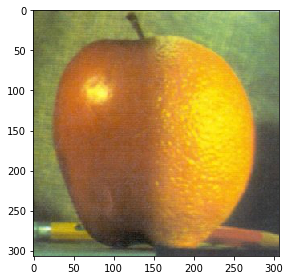

In [8]:
result = blend_images(image1, image2, mask)
io.imshow(result)